# Exploratory data analysis

We started our journey with a hypothesis: "_there should be some connection between amenities and traffic!_". Indeed, as a citizen, you wake up, drink a cup of coffee, go to work. During the day you eat lunch, do shopping, gym etcetera. So, there is a reason for you to leave home, right? And to get to so called a point of interest (POI) you use a certain mode of transport. Let us imagine that there is a single way to travel in the city: metro. With this notebook, we are going to explore what are the __relationships between amenities__ and the __underground traffic__.

One of the critical aspect of this study is the choice of "the right" resolution or scale of area to analyze. The options are: 
* operate with official statistical boundaries (boroughs and wards);
* create a custom hexgrid.

The are pros and cons of using each of these options. By using official statistical boundaries we are ensuring that the numbers are "correct". However, representing data in such a way can be misleading because each borough consists of different shapes and sizes, which then affects the summary values (e.g., population per borough) used in the analysis. The same area can be represented differently via differing scales, and this is potentially problematic. Defining a custom grid of identically-sized units and distributing the values across the units is one way to limit this effect. 

We will start our analysis by exploring whether or not amenities and population are "correlated." Secondly, we will cluster amenities into groups.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import numpy as np

from scipy import spatial
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from shapely.geometry import Point, Polygon, box, shape

# Load user-defined functions
from src.create_hexgrid import create_hexgrid
from src.vizualization import scatterplot, choropleth # , plot_hexgrid

# Do not display warnings
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-whitegrid')

## 1. Amenities and population

#### Statistical boundaries (wards or boroughs)

In [2]:
# Select the resolution
resolution = 'wards'
if resolution == 'wards':
    column_id = 'WD11CD_BF'
elif resolution == 'boroughs':
    column_id = 'LAD11NM'
else:
    raise ValueError("You haven't specified the resoultion or specified it wrongly.")
print(f'Chosen resolution : {resolution.capitalize()}')

Chosen resolution : Wards


Load datasets: Population, POI, and London shapefile

In [3]:
# Load the data
population = gpd.read_file(f'../data/processed/population/{resolution}.json')
population = population[[f'{column_id}', 'total_population', 'geometry']] # keep only the columns of interest
population.set_index(f'{column_id}', inplace=True) # change index to make merge easier
pois_counts = pd.read_csv(f'../data/processed/pois/pois_counts_{resolution}.csv')

# Change index to make merge easier
pois_counts.set_index('pois_category', inplace=True)

# Let's combine population and pois counts
df = pd.concat([pois_counts, population.T])
df.fillna(0, inplace=True)

# Prepare a GeoDataFrame
gdf = gpd.GeoDataFrame(df.T, geometry='geometry')
gdf.crs = population.crs
gdf.to_crs(epsg=3857, inplace=True)

# Make sure that all values are numeric
gdf.loc[:,:'total_population'] = gdf.loc[:,:'total_population'].apply(pd.to_numeric)

Can we find a pattern between the number of amenties by type and population?

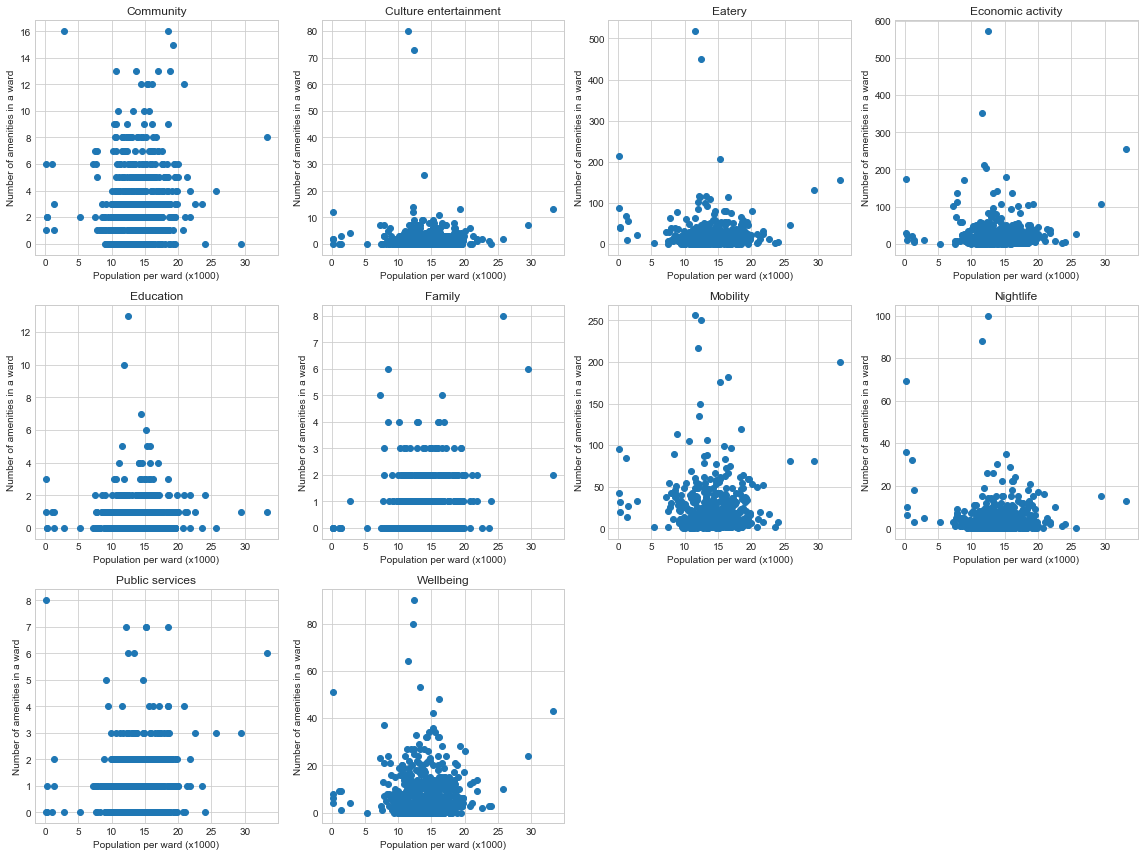

In [4]:
scatterplot(df, savefig=True)

What about with maps? Are there explainable patterns if visualize the distribution of amenities geographically?

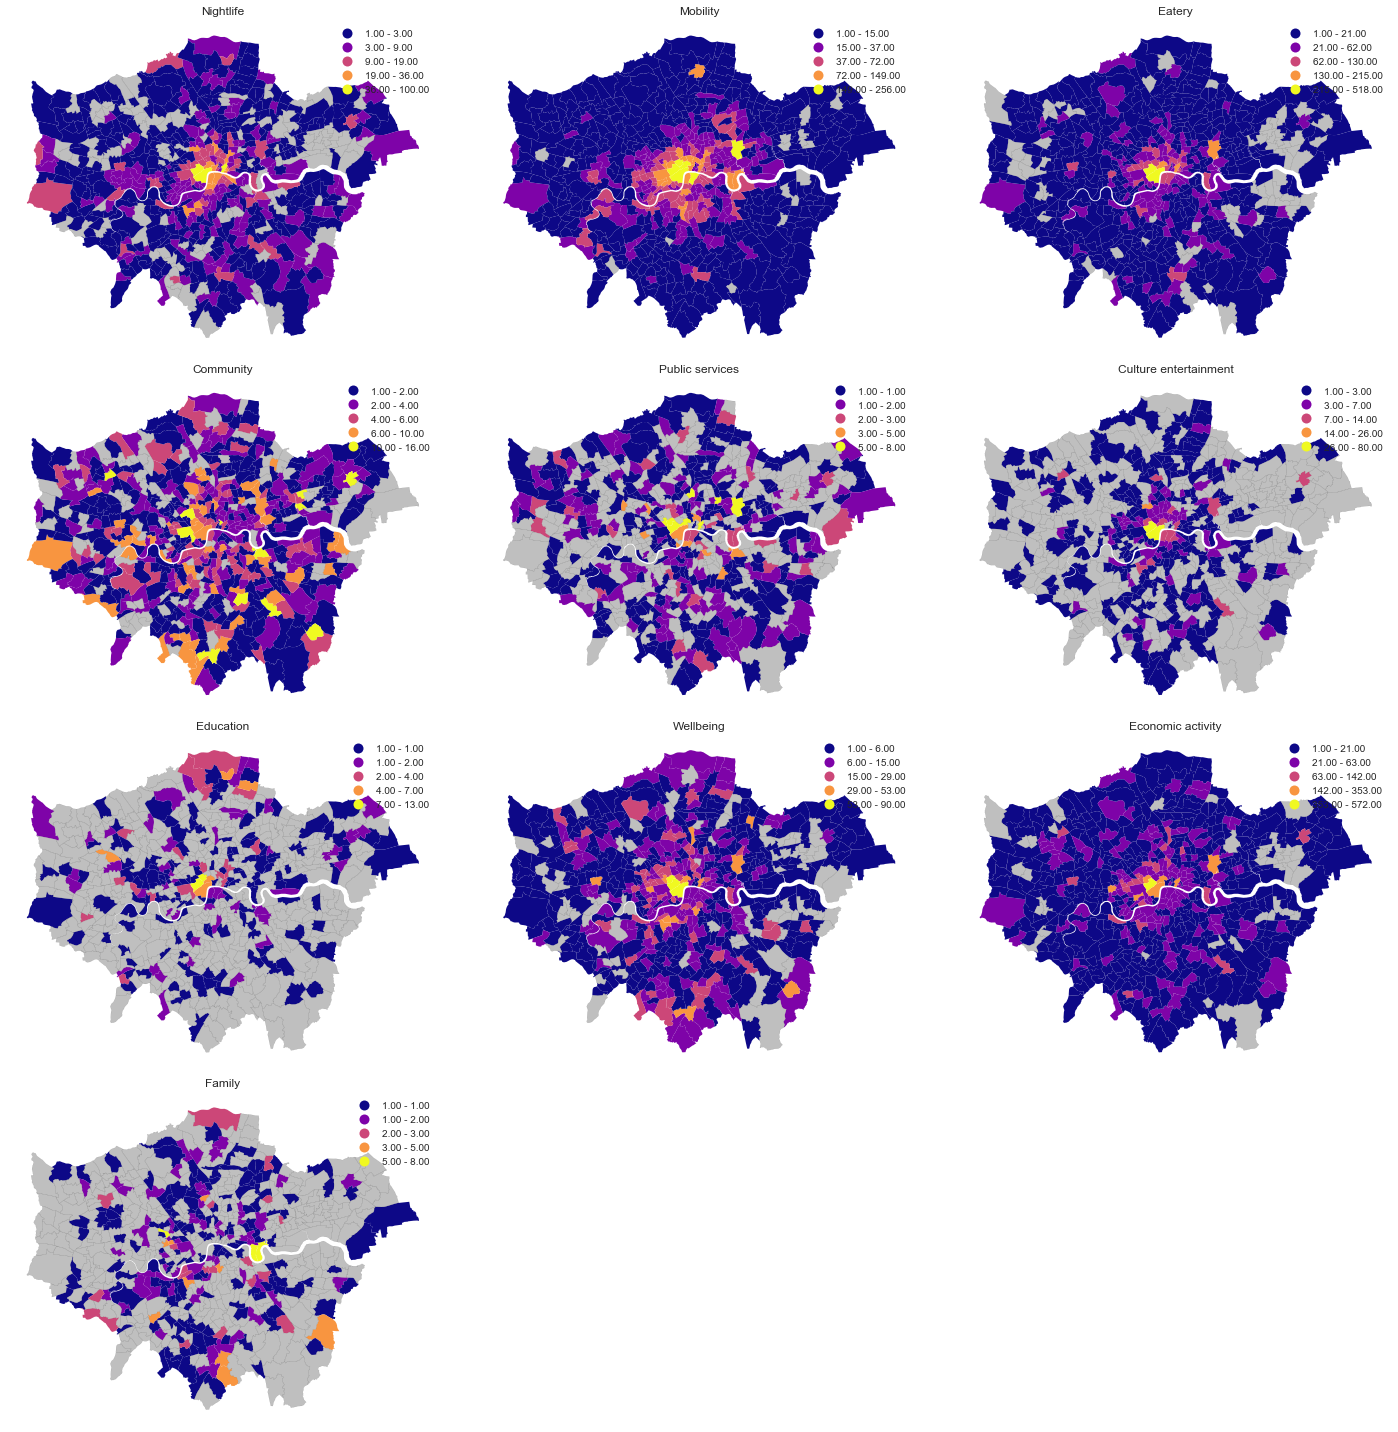

In [5]:
choropleth(gdf, cmap='plasma', savefig=True)

#### Hexgrid
Let's take a look with hexgrids.

In [6]:
# Load POIs data
pois = pd.read_csv('../data/processed/pois/pois.csv', low_memory=False)
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois.crs = {'init':'epsg:4326'}
pois_categories = pd.read_csv("../data/external/pois_categories.csv")

In [7]:
# Sort pois into categories
pois = pd.merge(pois, pois_categories, left_on='poi_type', right_on='pois') 
# pois.drop('amenity', axis=1, inplace=True)

# Remove amenities tagged 'misc'
pois = pois[pois['pois_category'] != 'misc']

In [8]:
# Polygons here = boroughs/wards
polygons = gdf[['geometry']].reset_index(drop=True)
polygons = polygons.to_crs(epsg=4326)

# Create a hexgrid
hex_res = 7
resolution = f'hex_id_{hex_res}'
buffer = 0.005
plot = False
hexgrid = create_hexgrid(polygons, hex_res=hex_res, buffer=buffer, plot=plot)
hexgrid.reset_index(drop=True, inplace=True)
hexgrid.crs = {'init': 'epsg:4326', 'no_defs': True}
# hexgrid.to_crs(3395).plot()
# plt.axis('off');

In [9]:
# Distribute population over the hexgrids equally (based on the area)
gdf.to_crs(epsg=4326, inplace=True)
gdf = gdf.reset_index(drop=True)

hexgrid['total_population'] = 0

hexgrid_polygons = [shape(polygon) for polygon in hexgrid["geometry"].tolist()]
polygons = [shape(polygon) for polygon in gdf["geometry"].tolist()]

for i, hexgrid_polygon in tqdm(enumerate(hexgrid_polygons), total=len(hexgrid_polygons)):
    for j, polygon in enumerate(polygons):
        if hexgrid_polygon.intersects(polygon):
            intersect = (hexgrid_polygon.intersection(polygon).area / hexgrid_polygon.area)
            hexgrid.loc[i, "total_population"] += (gdf.loc[j, "total_population"] * intersect)

100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:02<00:00, 165.54it/s]


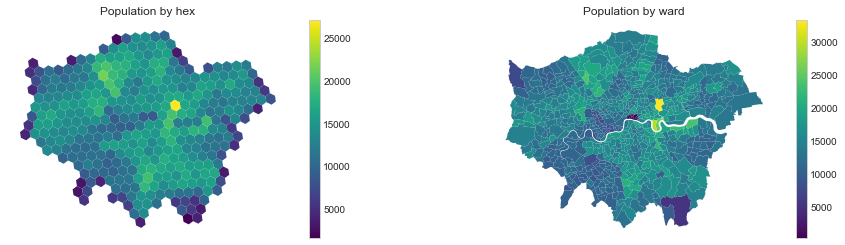

In [10]:
# Compare result visually 
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
hexgrid.to_crs(epsg=3395).plot(column='total_population', cmap='viridis', legend=True, ax=ax[0]) # scheme='fisher_jenks', 
gdf.to_crs(epsg=3395).plot(column='total_population', cmap='viridis', legend=True, ax=ax[1]) # , scheme='fisher_jenks', )
ax[0].axis('off')
ax[0].set_title(f'Population by hex')
ax[1].set_title(f'Population by ward')
ax[1].axis('off');

In [11]:
# How many POIs per hexagon?
pois_in_hex = gpd.sjoin(pois, hexgrid)
# pois_in_hex

# Create an empty column for counting
pois_in_hex['n'] = 1

# Pois in hex by category
pois_in_hex_by_cat = pois_in_hex.groupby(['pois_category', resolution]).sum()

In [12]:
hexgrid_population = hexgrid.set_index(resolution)['total_population']
# hexgrid.drop('total_population', axis=1, inplace=True)

In [13]:
x = np.arange(10)
ys = [i + x + (i * x)**2 for i in range(10)]
colors = cm.tab10(np.linspace(0, 1, len(ys)))

Is there a pattern between number of amenities and population when sorted by same-size hexagons?

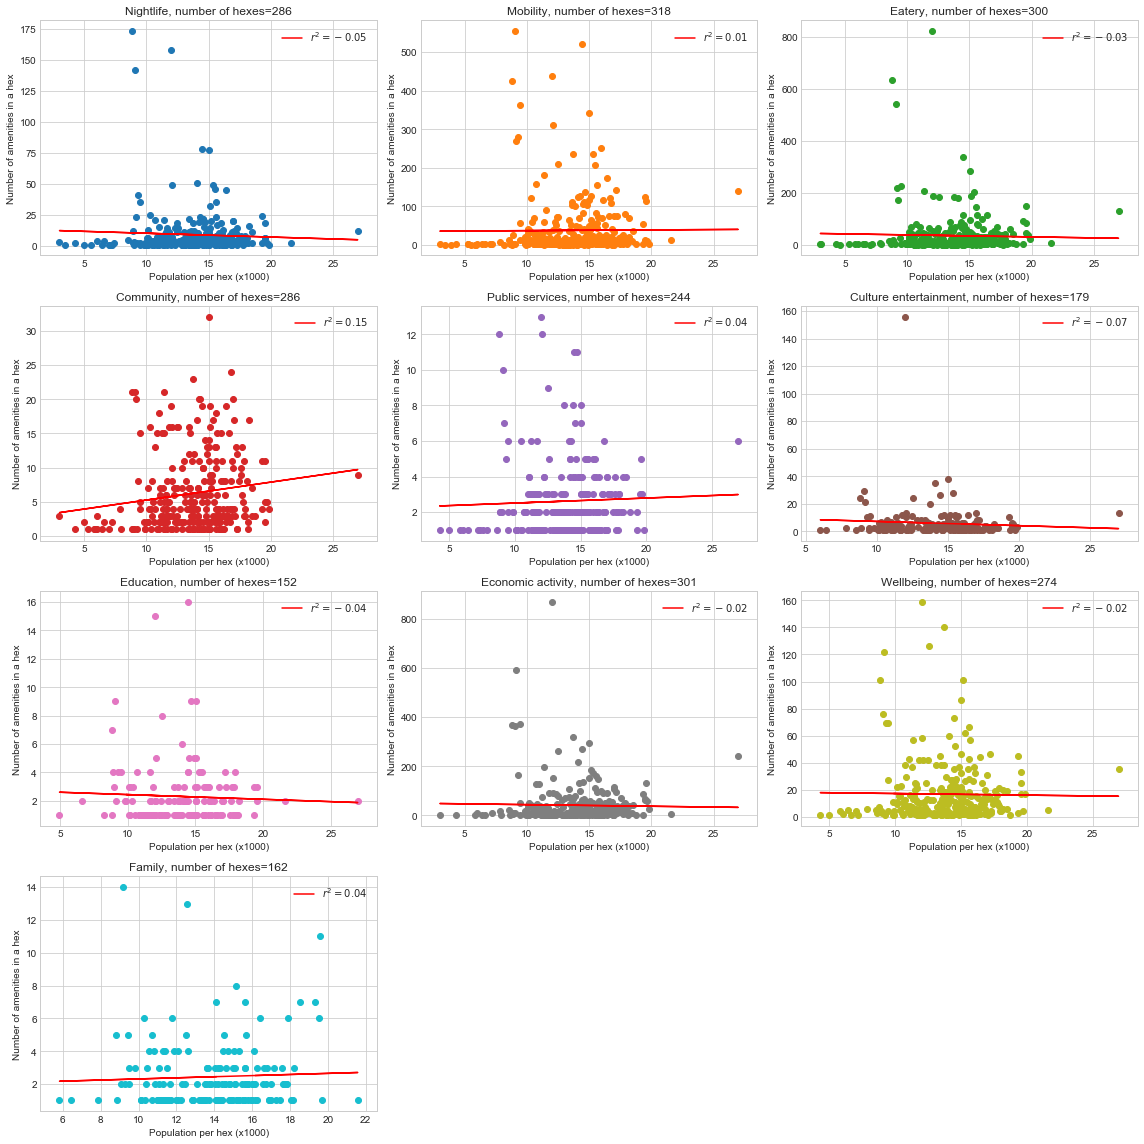

In [14]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merged = pd.merge(pois_in_hex_by_cat.loc[columns[k]], hexgrid, left_on=pois_in_hex_by_cat.loc[columns[k]].index, right_on=resolution)
        X = merged['total_population_y'].div(1000).values
        y = merged['n']
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
        line = slope * X + intercept
        ax[i, j].plot(X, line, label= f'$r^2={round(r_value, 2)}$', color='red')
        ax[i, j].scatter(X, y, color=colors[k])
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}, number of hexes={merged.shape[0]}')
        ax[i, j].set_ylabel('Number of amenities in a hex')
        ax[i, j].set_xlabel('Population per hex (x1000)')
        ax[i, j].legend()
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('../figures/scatter-hex.png', dpi=300)

Is this pattern more discernible when visualized on a map?

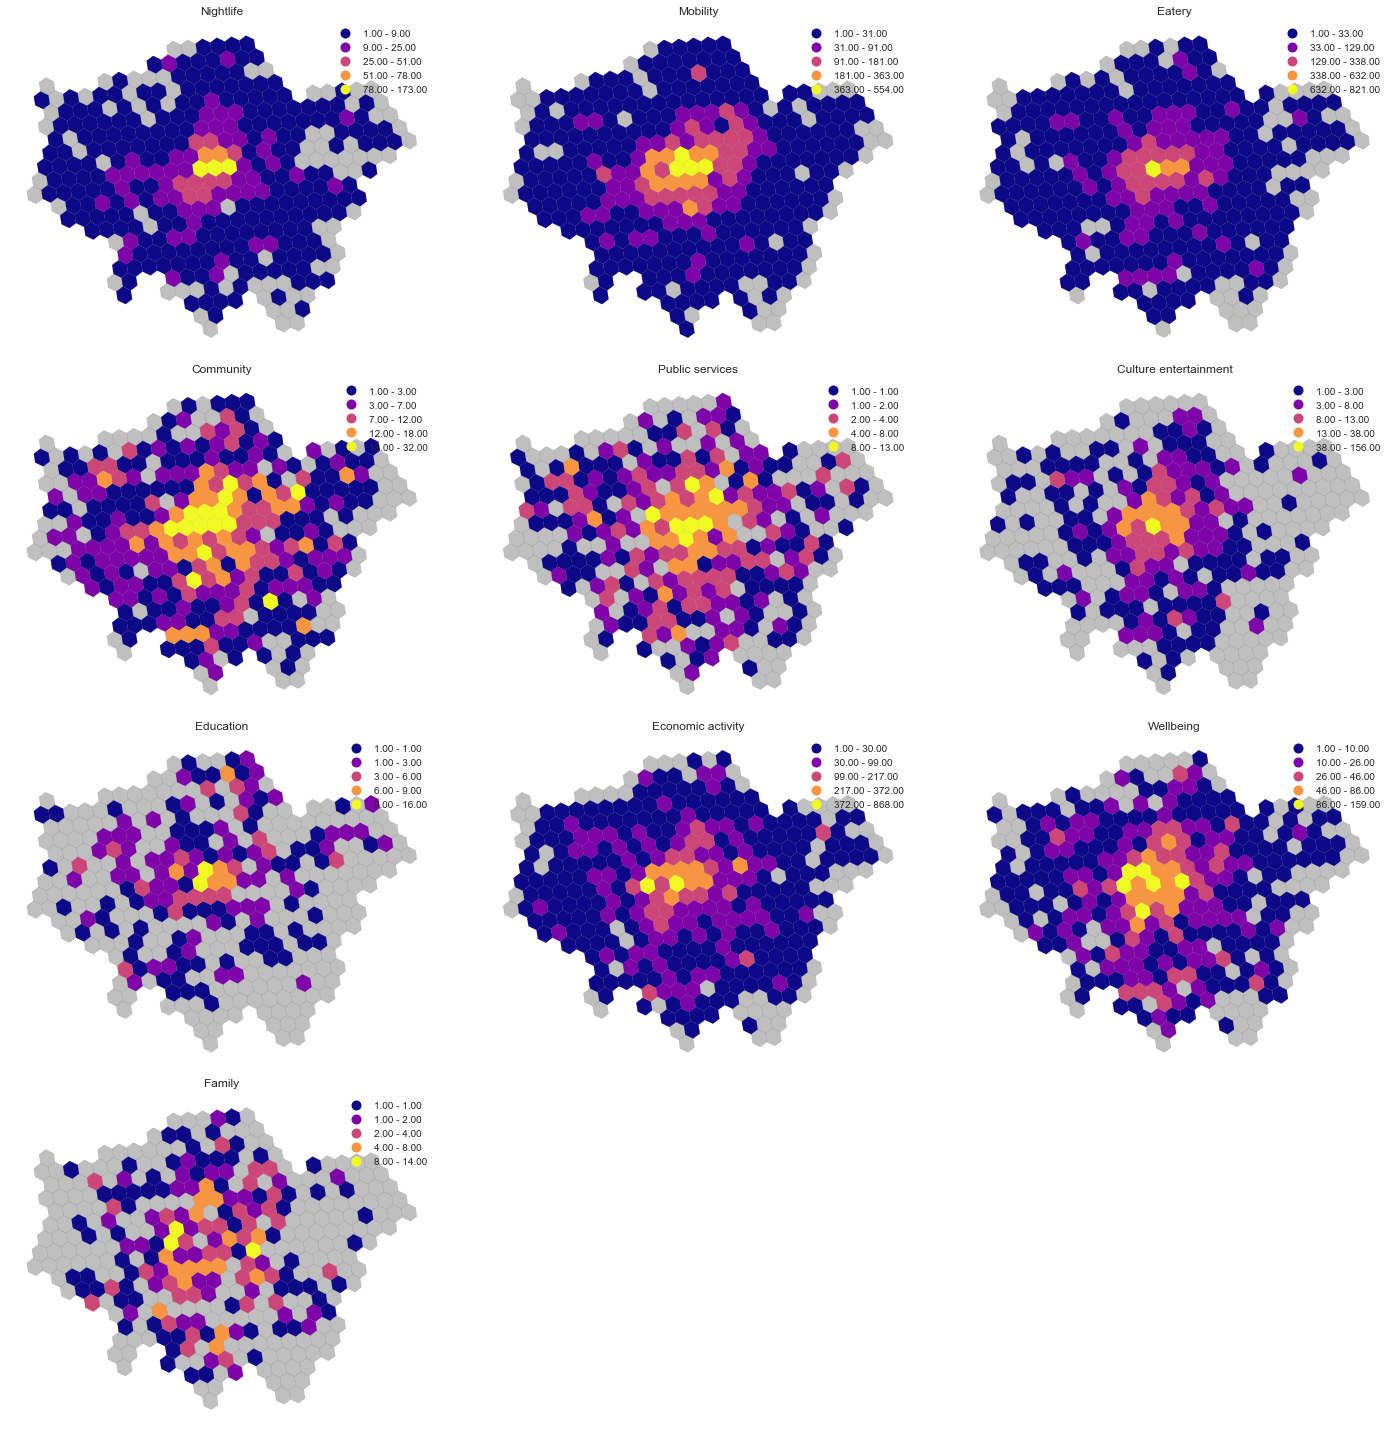

In [15]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merged = pd.merge(pois_in_hex_by_cat.loc[columns[k]], hexgrid, left_on=pois_in_hex_by_cat.loc[columns[k]].index, right_on=resolution)
        merged = gpd.GeoDataFrame(merged, geometry='geometry')
        merged.crs = {'init':'epsg:4326'}
        hexgrid.to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        merged.to_crs(epsg=3857).plot(column='n', ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('../figures/choropleth-hex.png', dpi=300)

## 2. Amenities and traffic

In [16]:
pois_counts = pois_in_hex.groupby(['pois_category', f'hex_id_{hex_res}']).agg(len)
pois_counts = pois_counts.reset_index()
pois_counts = pois_counts.pivot(index="pois_category", columns=f'hex_id_{hex_res}', values= "name")
pois_counts = pois_counts.fillna(0)
pois_counts = pois_counts.T

In [17]:
columns = pois_counts.loc[:,:'wellbeing'].columns.tolist()

How are the amenity types correlated? Specifically, are certain amenity types more often found alongside other amenity types?

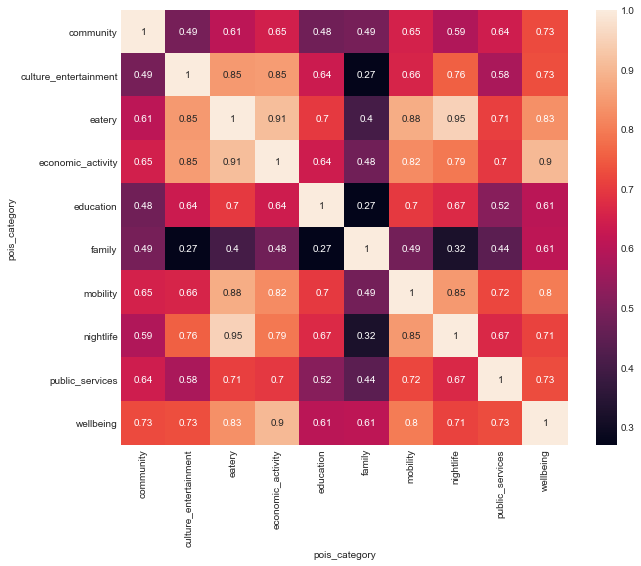

In [18]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(pois_counts.corr(), annot=True);

In [19]:
# Assign population
merged = pd.merge(pois_counts, hexgrid_population, left_index=True, right_index=True)

In [20]:
merged[columns] = merged[columns].div(merged['total_population'], axis=0).multiply(1000)

#### Clustering
First, we standardize the amenity counts (by type) to control for outliers.

In [21]:
X_scaled = StandardScaler().fit_transform(merged.loc[:,:'wellbeing'])

In [22]:
k_min = 2
k_max = 20

models = {}
labels = {}

init = 'k-means++'
n_init = 100
random_state = 1235

print(f'Perform K-means clustering with {n_init} {init} centorid initalizations.')

Perform K-means clustering with 100 k-means++ centorid initalizations.


In [23]:
for k in tqdm(range(k_min, k_max + 1)):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, random_state=random_state)
    models[k] = kmeans.fit(X_scaled)
    labels[k] = models[k].labels_

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.78it/s]


Evaluate clustering metrics to determine appropriate number of clusters to select.

In [24]:
# Silhouette, Calinski-Harabasz, Davies-Bouldin
clustering_metrics = {}
ss = {}
ch = {}
db = {}

delimiter = 1

for key, value in models.items():
    ss[key] = silhouette_score(X_scaled, labels[key], random_state=random_state)
    ch[key] = round(calinski_harabasz_score(X_scaled, labels[key]) / delimiter, 3)
    db[key] = round(davies_bouldin_score(X_scaled, labels[key]), 3)
    
clustering_metrics["Silhouette score"] = ss
clustering_metrics["Calinski-Harabasz"] = ch
clustering_metrics["Davies-Bouldin"] = db

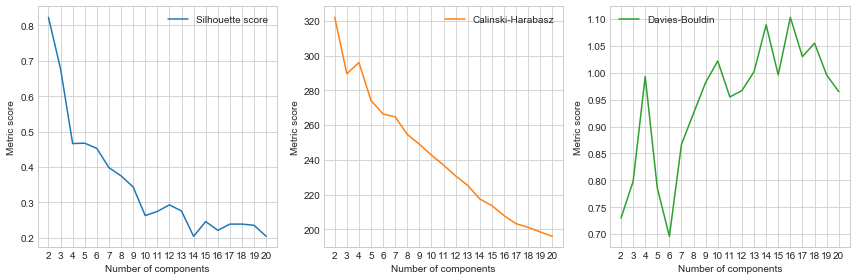

In [25]:
ax = pd.DataFrame(clustering_metrics).plot(subplots=True, layout=(1, 3), figsize=(12, 4), rot=0, xticks=np.arange(k_min, k_max + 1), sharex=False);
for i in range(0, 3):
    ax[0, i].set_xlabel('Number of components')
    ax[0, i].set_ylabel('Metric score')
plt.tight_layout()

Select number of clusters = 4.

In [26]:
n_clusters = 4
np.unique(labels[n_clusters], return_counts=True)

(array([0, 1, 2, 3]), array([251,  10,  84,   3], dtype=int64))

In [27]:
merged['label'] = labels[n_clusters]

We now take a look at amenity types and distributions per cluster.

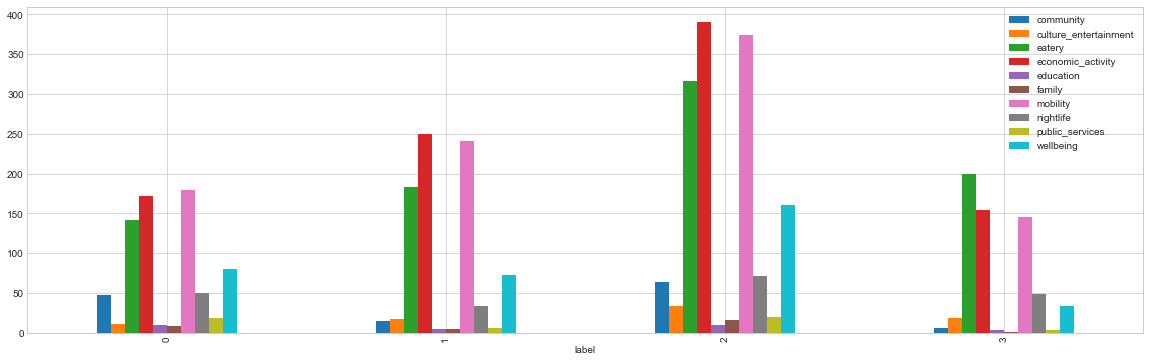

In [28]:
merged[columns + ['label']].groupby('label').sum().plot.bar(figsize=(20,6), rot=90);

In [29]:
merged = pd.merge(hexgrid, merged, left_on=f'hex_id_{hex_res}', right_index=True)

How are the clusters distributed spatially on a map?

In [30]:
pd.concat([merged[merged["label"].isin([0])].iloc[:,3:13].mean(),
          merged[merged["label"].isin([1])].iloc[:,3:13].mean(),
          merged[merged["label"].isin([0, 1])].iloc[:,3:13].mean(),
          merged[merged["label"].isin([2,3])].iloc[:,3:13].mean()], axis=1)

,0,1,2,3
community,0.190280,1.490297,0.240089,0.807091
culture_entertainment,0.044937,1.666708,0.107073,0.601177
eatery,0.565160,18.276347,1.243750,5.934341
economic_activity,0.684799,24.913506,1.613102,6.264249
education,0.037268,0.427679,0.052227,0.151673
family,0.032988,0.486072,0.050348,0.190109
mobility,0.713782,24.115167,1.610387,5.979322
nightlife,0.198277,3.308459,0.317441,1.379798
public_services,0.075335,0.600485,0.095455,0.266030
wellbeing,0.316637,7.311332,0.584633,2.230811


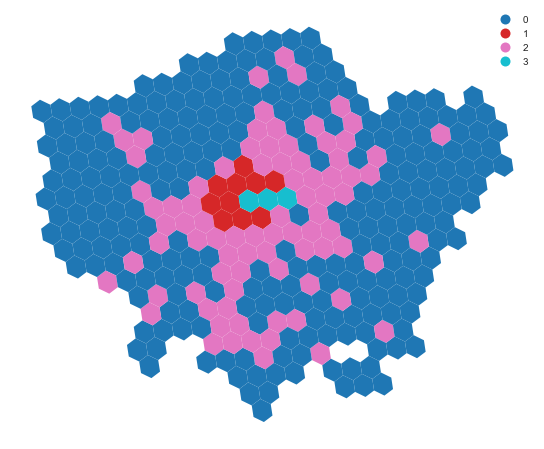

In [31]:
merged.to_crs(epsg=3857).plot(column='label', categorical=True, legend=True, figsize=(10,8))
plt.axis('off');

#### Station traffic
How does the travel volume (passenger exit counts) at these hexagons compare with each other?

In [32]:
# Connect station traffic and the number of amenities of a specific type
stations = gpd.read_file('../data/external/exit_station.json')
sjoin = gpd.sjoin(merged, stations, how="inner", op="contains")

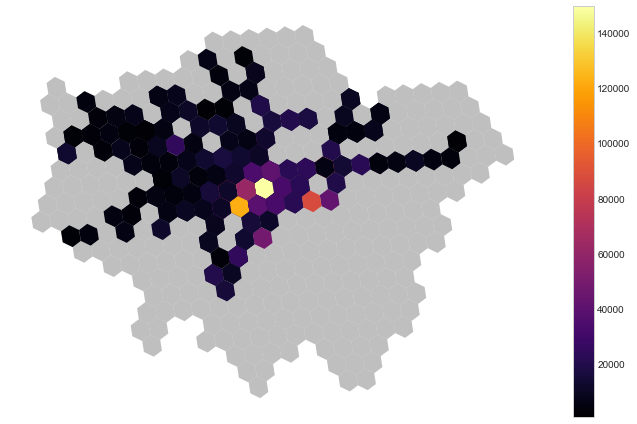

In [33]:
ax = hexgrid.to_crs(epsg=3395).plot(color='grey', alpha=.5,  figsize=(10,6))
sjoin.to_crs(epsg=3395).plot(column=' Total', cmap='inferno', ax=ax, legend=True);
plt.axis('off')
plt.tight_layout();

Can we find a relationship between number of amenities and traveler volume in these hexagons?

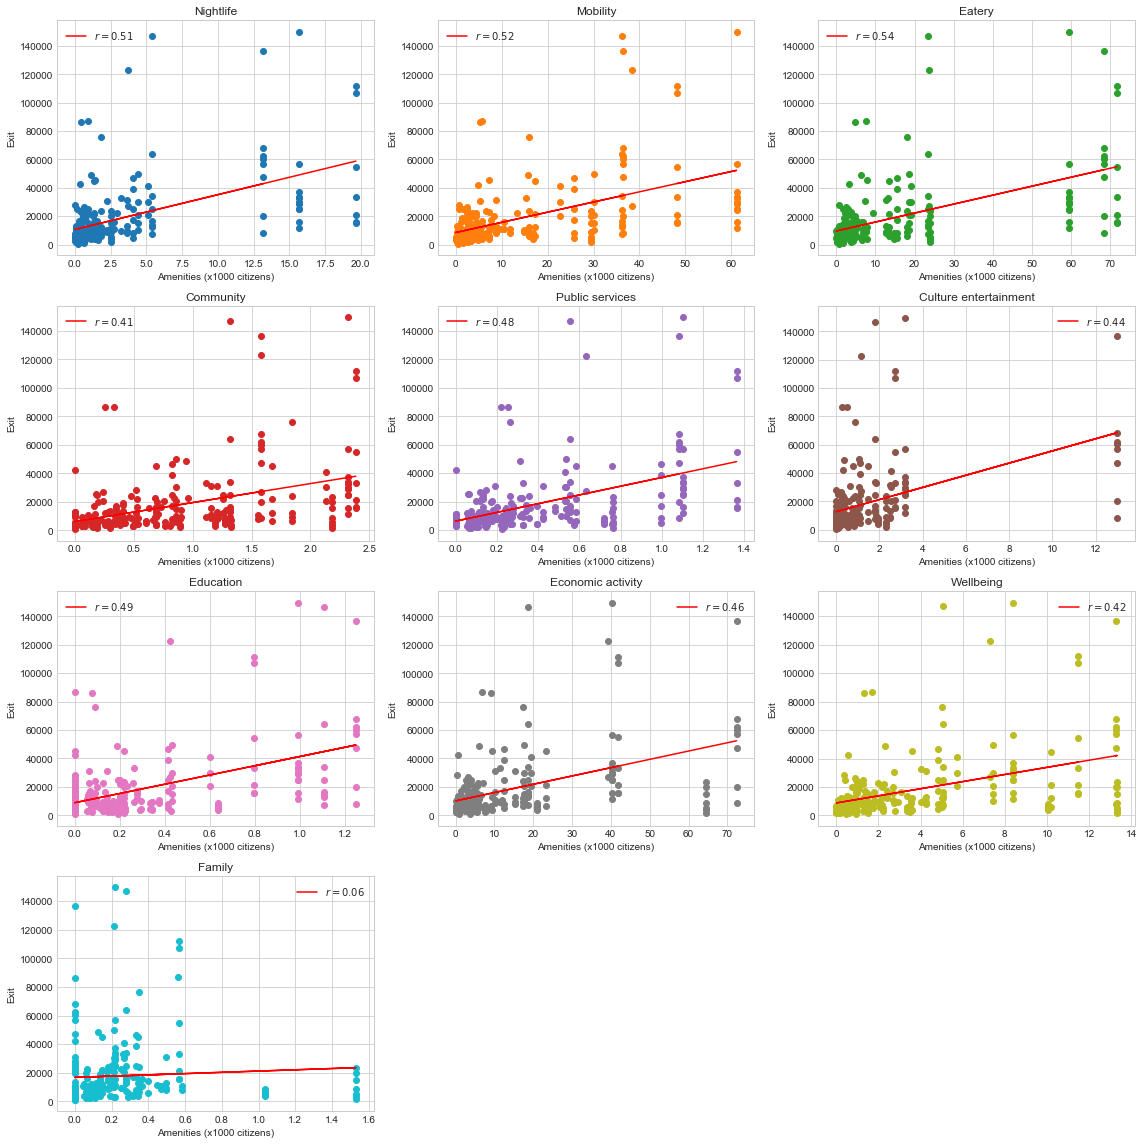

In [37]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        X = sjoin[columns[k]]
        y = sjoin[' Total']
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
        line = slope * X + intercept
        ax[i, j].plot(X, line, label= f'$r={round(r_value, 2)}$', color='red')
        ax[i, j].scatter(X, y, color=colors[k])
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].set_ylabel('Exit')
        ax[i, j].set_xlabel('Amenities (x1000 citizens)')
        ax[i, j].legend()
        # ax[i, j].set_yscale('log')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()

Do we find a pattern if we evaluate the aggregate travel volume between the clusters? 

Text(0.5, 0, 'Cluster label')

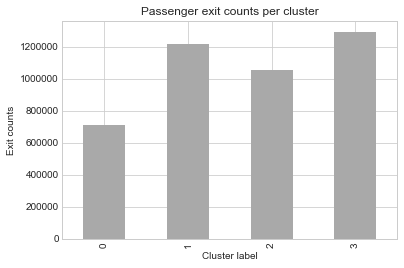

In [38]:
ax = sjoin.groupby('label_left').sum()[' Total'].plot.bar(color="darkgrey");
ax.set_title("Passenger exit counts per cluster")
ax.set_ylabel('Exit counts')
ax.set_xlabel('Cluster label')

In [39]:
sjoin.groupby('label_left').sum()[' Total']

label_left
0     711055
1    1215468
2    1053669
3    1293558
Name:  Total, dtype: int64